# Tutorial 4 - Modelling mineral-fluid reactions (EQ6) with pyDEW

First import the required packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyDEW

## Reaction of a harzburgite with water at 350$^\circ$C
In this calculation we will equilibrate a fluid with a olivine + opx + magnetite assemblage, then allow the resulting fluid to react with the same assemblage.

First, create an instance of the default system

In [2]:
dew_system = pyDEW.System()

/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecate

Set up the fluid. Let fO$_2$ be set by equilibrium with magnetite

In [3]:
molalities = {'NA+':0.05,
              'CL-':0.05}
mineral_eq = {'H4SIO4(AQ)':['ORTHOPYROXENE(SS)','ENSTATITE_OR'],
              'MG+2':['OLIVINE(SS)','FORSTERITE'],
              'FE+2':['OLIVINE(SS)','FAYALITE'],
              'O2(G)':'MAGNETITE'}
solid_solutions = {'OLIVINE(SS)':{'FORSTERITE':0.9, 'FAYALITE':0.1},
                   'ORTHOPYROXENE(SS)':{'ENSTATITE_OR':0.8,'FERROSILITE':0.2}}
T = 350.0 + 273.15
P = 10000.0

Run the EQ3 calculation to generate a fluid:

In [4]:
dew_fluid = pyDEW.Fluid(dew_system, T, P, molalities=molalities, mineral_eq=mineral_eq, solid_solutions=solid_solutions, uacion='NA+')

Set up the EQ6 calculation. Each reactant must be listed, with the number of moles that will be added during the reaction. If the reactant is a solid solution then its composition must be given also.

In [5]:
reactants = [{'reactant': 'OLIVINE(SS)',
              'moles': 2.0,
              'composition':{'FORSTERITE':0.9,'FAYALITE':0.1}},
             {'reactant': 'ORTHOPYROXENE(SS)',
              'moles': 2.0,
              'composition':{'ENSTATITE_OR':0.8,'FERROSILITE':0.2}},
             {'reactant': 'MAGNETITE',
              'moles': 0.2}]

Now generate the reaction. When creating an instance of the Reaction class the following things happen:
1. If the reaction is being performed at a different temperature or pressure than the fluid was generated at, then a new version of DATA0 will be created, and EQPT run.
2. The EQ6 input file will be generated, using the pickup file generated by EQ3 when the fluid was created. Since it needs the EQ3 generated pickup file, the fluid must be regenerated everytime you want to re-run the EQ6 calculation.
3. The EQ6 executable is copied into the working directory and run. The EQ6 executable is then removed.
4. The results (from the output and tab files) are read, and the results are stored in class attributes. More results are stored within in Reaction.output, but the most useful ones can be accessed more directly, as shown below.

In this case we run the calculation in titration mode, but we could also have run it in closed-system mode (the default choice).

In [6]:
dew_reaction = pyDEW.Reaction(dew_fluid, T, P, reactants, calculation_mode='titration')

We can inspect how the pH varied throughout the reaction. Notice the first entry is discarded, mostly out of convenience for plotting.

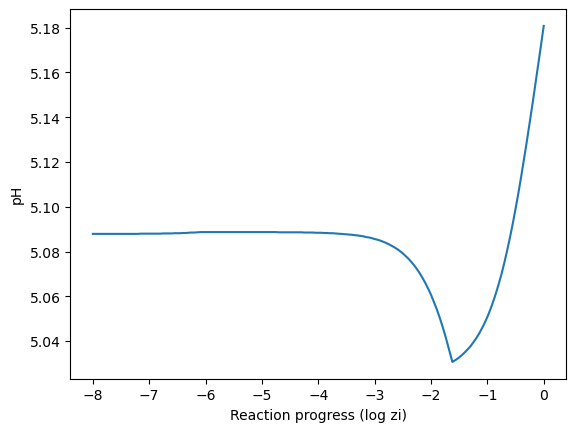

In [7]:
f,a = plt.subplots(dpi=100)
a.plot(dew_reaction.logzi[1:], dew_reaction.pH[1:])
a.set_xlabel('Reaction progress (log zi)')
a.set_ylabel('pH')
plt.show()

In [8]:
dew_reaction

In this case the pH changed very little. We can also see how the elemental budget in the fluid changed during the reaction:

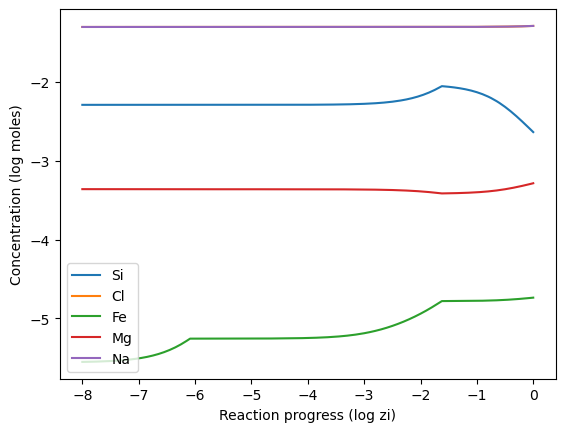

In [9]:
f,a = plt.subplots(dpi=100)
for el in list(dew_reaction.elements.columns):
    a.plot(dew_reaction.elements.index[1:], dew_reaction.elements[el].iloc[1:], label=el)
a.legend()
a.set_xlabel('Reaction progress (log zi)')
a.set_ylabel('Concentration (log moles)')
plt.show()

Next we can see which phases precipated during reaction:

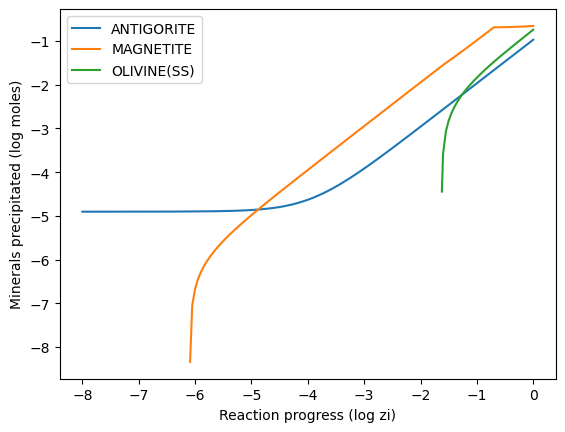

In [10]:
f,a = plt.subplots(dpi=100)
for mi in list(dew_reaction.minerals.columns):
    a.plot(dew_reaction.minerals.index[1:], dew_reaction.minerals[mi].iloc[1:], label=mi)
a.legend()
a.set_xlabel('Reaction progress (log zi)')
a.set_ylabel('Minerals precipitated (log moles)')
plt.show()

Olivine is precipitating, but what is its composition?

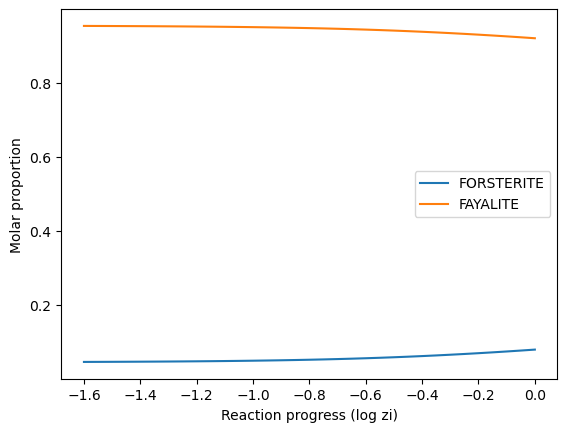

In [11]:
f,a = plt.subplots(dpi=100)
for mi in list(dew_reaction.solid_solutions.columns):
    a.plot(dew_reaction.solid_solutions.index[1:], dew_reaction.solid_solutions[mi].iloc[1:], label=mi)
a.legend()
a.set_xlabel('Reaction progress (log zi)')
a.set_ylabel('Molar proportion')
plt.show()

Maybe we are interested specifically in how Mg is complexed in this fluid. We can also extract this information from the results:

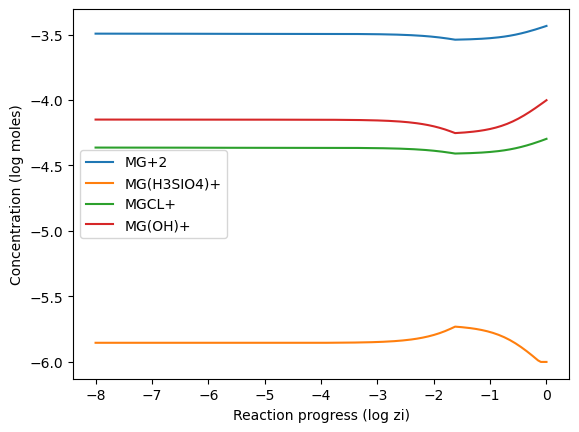

In [12]:
f,a = plt.subplots(dpi=100)
for sp in list(dew_reaction.species_concs.columns):
    if 'MG' in sp:
        a.plot(dew_reaction.species_concs.index[1:], dew_reaction.species_concs[sp].iloc[1:], label=sp)
a.legend()
a.set_xlabel('Reaction progress (log zi)')
a.set_ylabel('Concentration (log moles)')
plt.show()

To see all the options available when creating a reaction, you can view the documentation like this:

In [13]:
pyDEW.Reaction?

Init signature:
pyDEW.Reaction(
    fluid,
    T,
    P,
    reactants=[],
    bulk_composition={},
    bulk_composition_units='mol_elements',
    mols_bulk_composition=1.0,
    dT=0.0,
    calculation_mode='closed',
    point_calculation=False,
    zimax=1.0,
    eq6_executable_name=None,
    eq3_working_directory='working',
    eqpt_working_directory='working',
    eq6_working_directory='working',
    eqpt_executable_name=None,
    dummy_temperature=300.0,
)
Docstring:     
Class for enabling EQ6 calculations. The working directory will be the same as used when
generating the Fluid.

Attributes
----------

Parameters
----------
fluid : pyDEW.Fluid object
    The fluid object to react with
t : float
    The temperature (K)
p : float
    The pressure (bars)
reactants : list of dicts, default: []
    The reactants for the calculation. The dicts should be formatted with keys and values:
    - reactant (str)
      The name of the mineral
    - moles (float)
      The moles in the reaction

## Calculating volumes of minerals
pyDEW does not automatically calculate the modal volumes of the minerals, however this can be done easily using thermoengine.

First we will import pandas to help manipulate the data tables:

In [36]:
import pandas as pd

Then we need to create a list of mineral names stored in the system object:

In [32]:
mineral_names = []
for ph in dew_system.minerals:
    mineral_names.append(ph.abbrev)

And now, let's do the calculation:

In [48]:

# Create a DataFrame for the results:
mineral_volumes = pd.DataFrame()

# For each mineral in the results:
for mineral in dew_reaction.minerals.columns:
    vols = []
    
    # Check if the mineral is a solid solution:
    if mineral in dew_system.solid_solutions:
        
        # Get a list of the pure endmember names:
        ss_endmembers = solid_solutions[mineral]
        
        # Iterate through calculation steps:
        i = 0
        for rp, row in dew_reaction.minerals.iterrows():
            # If no SS present, then the row won't exist in the SS dataframe:
            if rp in dew_reaction.solid_solutions.index:
                ss_row = dew_reaction.solid_solutions.loc[rp]

                # Calculate the molar volume for the SS composition
                # This assumes ideal mixing, as all calculations in EQ3/6 do
                molvol = 0.0
                for ssend in ss_endmembers:
                    ssend_obj = dew_system.minerals[mineral_names.index(ssend)]
                    molvol += ssend_obj.volume(dew_reaction.T[i], dew_reaction.P) * ss_row[ssend]

                # Now calculate the actual volume:
                vols.append(molvol * 10**row[mineral])
            
            else:
                vols.append(np.nan)
            
            i += 1
        
    
    # Check if the mineral is a pure mineral:
    elif mineral in mineral_names:
        
        # Extract the coder object for the mineral:
        mineral_obj = dew_system.minerals[mineral_names.index(mineral)]
        
        # Calculate the volume for each step of the calculation:
        i = 0
        for rp, row in dew_reaction.minerals.iterrows():
            vols.append(mineral_obj.volume(dew_reaction.T[i], dew_reaction.P) * 10**row[mineral])
            i += 1
        
    # Check if something terrible has happened:
    else:
        print("WARNING! {} not found in system.".format(mineral))
    
    
    mineral_volumes[mineral] = vols
    
mineral_volumes.index = dew_reaction.minerals.index

We can normalise:

In [49]:
normalised_volumes = mineral_volumes.div(mineral_volumes.sum(axis=1), axis=0)

And make a plot!

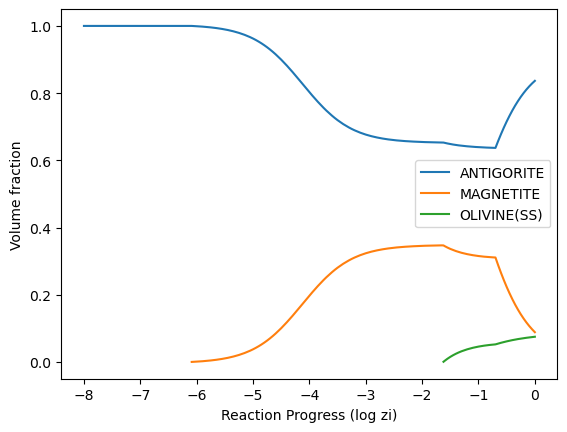

In [57]:
f, a = plt.subplots()

for mineral in normalised_volumes.columns:
    a.plot(normalised_volumes.index[1:], normalised_volumes[mineral].iloc[1:],
           label=mineral)
        
a.set_xlabel('Reaction Progress (log zi)')

a.set_ylabel('Volume fraction')

a.legend()
    
plt.show()